In [17]:
# required python libraries
import pandas as pd
import numpy as np
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
import time

# scikit-learn models and functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

# Logistic Regression Models
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SequentialFeatureSelector  # slow processing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import training & final test data
df_train = pd.read_csv('../data/processed/clean_train.csv')
df_test = pd.read_csv('../data/processed/clean_test.csv')

# Extract the column TARGET_5Yrs and save it into variable called target
target = df_train.pop('TARGET_5Yrs')

labels = df_train.columns.tolist() 
print(labels)

# original list for reference
# ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']
# ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']

# copy original data
df_fix_train = df_train.copy()
df_fix_test = df_test.copy()

['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']


In [25]:
# only keep selected features / cols
def select_features(df_train, df_test, keep_cols=['']):
    # take copies of the Cleaned data up to now - so we can rerun from here different feature selections
    df_clean_new = df_train.copy()
    df_clean_new_test = df_test.copy()
    
    return df_clean_new[keep_cols], df_clean_new_test[keep_cols]


# ALL Features for baseline testing for training models
# df_clean_R1, df_clean_R1_test = select_features(df_cleaned, df_clean_test, keep_cols=labels)
# check still the same number of rows & columns as original cleaned training data
# print('df_clean_R1 row,cols    ',df_clean_R1.shape)

In [779]:
df_train[df_train['GP']<19].sort_values(['GP'], ascending=True).head(10)

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
5323,-8,5.8,1.5,0.6,1.9,33.6,0.0,0.2,13.9,0.1,0.2,63.6,0.0,0.5,0.6,0.2,0.1,-0.5,0.3
7400,-3,6.1,2.1,0.8,1.9,39.1,-0.2,-0.5,19.2,0.6,0.9,70.2,0.6,0.4,0.8,0.1,0.3,0.1,0.4
6450,1,5.0,1.2,0.5,1.2,42.2,0.1,0.1,11.9,0.2,0.3,58.0,0.1,0.3,0.4,0.4,0.3,-0.1,0.3
3093,3,8.3,2.0,0.8,2.2,35.0,0.2,0.8,18.6,0.4,0.9,38.9,0.4,0.9,1.4,0.5,0.3,0.2,0.3
2763,4,3.8,0.9,0.3,1.0,33.5,0.1,0.2,29.0,0.1,0.1,76.5,0.0,0.3,0.4,0.1,0.1,0.1,0.1
5008,6,5.7,1.2,0.5,1.3,41.5,0.3,1.3,8.0,0.1,0.1,65.6,0.0,0.4,0.5,0.3,0.1,0.1,0.3
4598,8,5.1,1.5,0.7,2.0,36.1,0.2,1.0,11.0,0.1,0.1,67.2,0.1,0.4,0.5,0.1,0.1,-0.1,0.2
7847,8,6.4,1.5,0.5,1.5,38.8,-0.1,-0.1,20.2,0.3,0.5,68.5,0.2,0.4,0.7,0.5,0.3,-0.1,0.3
7871,10,5.5,1.8,0.6,1.5,43.2,0.3,0.9,11.2,0.3,0.5,63.0,0.2,0.4,0.7,0.4,0.1,-0.1,0.4
7671,10,14.8,4.0,1.5,3.7,40.5,0.6,1.7,31.6,0.6,0.9,66.0,0.6,1.5,2.2,0.6,0.4,0.2,0.7


In [5]:
# count negative values in each column
df_neg = pd.DataFrame()
for i in range(len(df_train.columns)):
    df_neg[labels[i]] = [df_train[df_train[labels[i]]<0][labels[i]].count()]  
    
df_neg_test = pd.DataFrame()
for i in range(len(df_test.columns)):
    df_neg_test[labels[i]] = [df_test[df_test[labels[i]]<0][labels[i]].count()]  

print('Training data - negative values')
display(df_neg)

print('Training data - negative values')
display(df_neg_test)

Training data - negative values


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,2,0,0,0,0,0,1629,1658,878,0,0,1,0,0,0,0,0,1048,0


Training data - negative values


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0,0,0,0,0,0,775,773,435,0,0,0,0,0,0,0,0,456,0


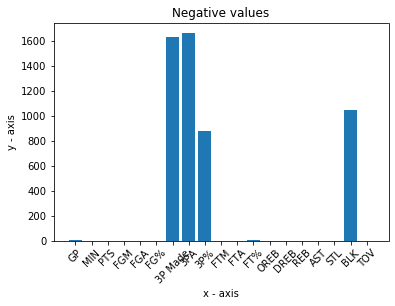

In [781]:
neg_val = df_neg.transpose()

# plotting a bar chart negative values
plt.bar(np.arange(len(labels)), neg_val[0], tick_label=labels) # , color = ['red', 'green'])
 
# naming the x-axis
plt.xlabel('x - axis')
plt.xticks(rotation=45)
# naming the y-axis
plt.ylabel('y - axis')
# plot title
plt.title('Negative values')
 
# function to show the plot
plt.show()

In [782]:
# check out negative GP
print('Negative values - GP')
display(df_fix_train[df_fix_train['GP']<=0])

Negative values - GP


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
5323,-8,5.8,1.5,0.6,1.9,33.6,0.0,0.2,13.9,0.1,0.2,63.6,0.0,0.5,0.6,0.2,0.1,-0.5,0.3
7400,-3,6.1,2.1,0.8,1.9,39.1,-0.2,-0.5,19.2,0.6,0.9,70.2,0.6,0.4,0.8,0.1,0.3,0.1,0.4


In [670]:
# BLK negative = 1048 rows
print('Negative values - BLK')
display(df_fix_test.loc[(df_fix_test['BLK']<0)][0:5])

Negative values - BLK


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
7,53,12.1,4.7,1.8,4.1,44.1,0.1,0.2,25.7,0.9,1.0,80.2,0.6,1.1,1.6,0.8,0.4,-0.2,0.6
30,63,19.5,10.7,4.5,9.2,49.1,0.8,2.2,44.4,1.1,1.3,83.0,0.3,1.1,1.4,3.4,1.0,-0.5,1.6
81,68,14.8,6.8,2.7,5.2,50.9,0.4,0.9,37.3,1.2,1.5,84.0,0.8,1.3,2.2,1.1,0.3,-0.3,0.9
83,47,10.9,4.5,1.8,3.9,43.5,0.5,1.5,36.5,0.9,1.3,70.4,0.5,0.7,1.3,0.8,0.5,-1.0,0.8


In [671]:
# 3P Made negative = 1629 rows
print('Negative values - 3P Made')
display(df_fix_test.loc[(df_fix_test['3P Made']<0)][0:5])

Negative values - 3P Made


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
5,59,16.1,7.1,2.8,4.5,62.0,-0.1,-0.6,3.4,1.7,2.7,58.6,1.8,2.6,4.6,0.6,0.6,0.4,0.9
6,45,8.3,3.2,1.4,2.8,46.4,-0.5,-1.6,8.9,0.5,0.7,69.3,0.5,0.5,1.2,0.2,0.1,0.2,0.4
16,78,23.9,8.1,3.1,5.8,52.1,-0.1,-0.1,33.8,2.1,3.2,64.3,1.4,2.3,3.7,1.4,0.6,0.3,1.8
18,27,8.5,1.6,0.7,1.4,50.4,-0.2,-0.6,22.4,0.1,0.2,55.8,0.6,1.1,1.5,0.4,0.3,0.0,0.4
21,59,35.0,20.5,8.7,14.8,62.3,-0.5,-1.4,0.0,4.2,6.0,69.2,6.9,7.2,13.8,0.9,1.5,3.5,2.4


In [6]:
# calculate mean for cols with negative values - update those values with the mean
df_fix_train = df_train.copy()
df_fix_test = df_train.copy()

def fix_negative_values(df_fix, df_neg_count, show=False, fix=False, title=''):
    if title!='':
        print(title)
        
    df_neg_fix = df_fix.copy()
    for i in range(len(df_neg_count.columns)):
        neg_val = int(df_neg_count.iloc[:,i].values)
        if neg_val>0:
            mean_val = df_neg_fix[labels[i]].loc[(df_neg_fix[labels[i]]>0)].mean()
            if show==True:
                print(labels[i],mean_val)

            if fix==True:
                # update negative values with the mean for that column
                df_neg_fix[labels[i]].loc[(df_neg_fix[labels[i]]<0)]=mean_val
                
    return df_neg_fix
    
fix_negative_values(df_fix_train, df_neg, True, False, 'Training data negative cols - mean') 
print('')
fix_negative_values(df_fix_test, df_neg_test, True, False, 'Test data negative cols - mean') 
print('')

Training data negative cols - mean
GP 62.7949487371843
3P Made 0.4482098982098982
3PA 1.2396929108134596
3P% 22.930386507378778
FT% 71.3764095511939
BLK 0.3967156166114006

Test data negative cols - mean
3P Made 0.4482098982098982
3PA 1.2396929108134596
3P% 22.930386507378778
BLK 0.3967156166114006



In [784]:
print('before fix 3PA:',list(df_fix_train['3PA'].loc[(df_fix_train['3PA']<0)])[0:20])
print('before fix BLK:',list(df_fix_train['BLK'].loc[(df_fix_train['BLK']<0)])[0:20])

# set negative values to the mean
df_fix_train = fix_negative_values(df_fix_train, df_neg, False, True, '')  
df_fix_test = fix_negative_values(df_fix_test, df_neg_test, False, True, '')  

print('\nafter fix 3PA :',df_fix_test['3PA'].loc[(df_fix_test['3PA']<0)])
print('after fix BLK :',df_fix_test['BLK'].loc[(df_fix_test['BLK']<0)])

before fix 3PA: [-1.0, -0.5, -0.1, -0.6, -1.0, -0.2, -0.7, -0.5, -0.4, -0.1, -1.6, -0.6, -0.1, -0.7, -1.6, -1.1, -0.3, -0.6, -0.7, -0.4]
before fix BLK: [-0.2, -0.2, -0.1, -0.1, -0.7, -0.1, -0.1, -0.2, -0.1, -1.7, -0.2, -0.7, -0.3, -0.2, -0.2, -0.5, -0.1, -0.1, -0.1, -0.1]

after fix 3PA : Series([], Name: 3PA, dtype: float64)
after fix BLK : Series([], Name: BLK, dtype: float64)


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

# set defaults
random_state=100
scaler = StandardScaler()

# Prepare training data for modelling - Standardising, Resampling for imbalanced data
def Prep_Model_Data(df_clean, target, scaler='', resample='', random_state=8):
    features_no = len(df_clean.columns)
    
    # rescale eg: scaler = StandardScaler()
    if scaler!='':
        df_clean = scaler.fit_transform(df_clean)
        # df_clean_test = scaler.fit_transform(df_clean_test)

    #---------------------------------------------------------------------------------------
    # Split randomly the dataset with random_state=8 into 2 different sets: data (80%) and test (20%)
    X_data, X_test, y_data, y_test = train_test_split(df_clean, target, test_size=0.2, random_state=random_state)

    # Split the remaining data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state) 
    
    #---------------------------------------------------------------------------------------
    # RESAMPLE if indicated
    
    # Original Training data
    if resample=='NO RESAMPLE' or resample=='':
        X_train_res, y_train_res = X_train, y_train
        X_val_res, y_val_res =  X_val, y_val
        X_test_res, y_test_res =  X_test, y_test
        #print(resample,'NO Resample -',features_no,'Features')
    
    # SMOTE - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='SMOTE':
        X_train_res, y_train_res = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = SMOTE(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = SMOTE(random_state=random_state).fit_resample(X_test, y_test)
        #print(resample,'Resample -',features_no,'Features')

    # ADASYN - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='ADASYN':
        X_train_res, y_train_res = ADASYN(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = ADASYN(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = ADASYN(random_state=random_state).fit_resample(X_test, y_test)
       
    return X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res


In [786]:
from sklearn.metrics import roc_auc_score, make_scorer

def Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, classifier, features='all', resample='resample'):
    t_start = time.process_time()
    # fit model
    classify = classifier.fit(X_train_res, y_train_res)
    t_end = time.process_time()       
    t_diff = t_end - t_start

    #--------------------------------------------------------------------------
    # Compare accuracy of the given test data
    
    # baseline target average
    y_mode = y_train_res.mode()
    
    if resample=='NO RESAMPLE' or resample=='':
        y_base_res = np.full((len(y_train_res), 1), y_mode)
    else: 
        y_base_res = np.full((len(y_train_res), 1), y_mode[0])

    # for debugging during dev/test
    if 1==2:
        print('mode',y_train_res.mode(), '\ttype:',type(y_train_res.mode()))
        print('len(X_train)',len(X_train_res))
        print('len(y_train)',len(y_train_res))
        print('y_base_res',y_base_res)

    #--------------------------------------------------------------------------
    # final test (unseen) data AUC score
    pred_prob = classifier.predict_proba(X_test_res)
    auc_score = roc_auc_score(y_test_res, pred_prob[:,1])
    
    # simple print of accuracy scores
    if 1==2:
        print(f"Compare accuracy between data sets - testing {features} features ")
        print(f"Classifier - {classify}")
        print(f"Imbalanced data fix - {resample}")
        print("Baseline:     ",accuracy_score(y_train_res, y_base_res))
        print("Train data:   ",classifier.score(X_train_res, y_train_res))
        print("Validation:   ",classifier.score(X_val_res, y_val_res))
        print('Test data auc:',auc_score,'\n')    
    
    clf_str = f'{classify}'
    clf_n = clf_str.find('(')
    
    df_scores = []
    df_scores.append((clf_str[0:clf_n], 'None' if resample=='' else resample, X_train_res.ndim,
                 accuracy_score(y_train_res, y_base_res), 
                 classifier.score(X_train_res, y_train_res),
                 classifier.score(X_val_res, y_val_res),
                 roc_auc_score(y_test_res, pred_prob[:,1]) ))
    
    return classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, df_scores


In [384]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# MLPClassifier parameters
activation='logistic'
solver='adam'     # sgd, adam (default)
alpha=0.01        # 0.0001 default
max_iter=300
batch_size=100    

random_state=100

# Classification Models defined - MLPClassifier()
clf_NN_MLP=MLPClassifier(activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, random_state=random_state)

# Classification Models defined - LogisticRegression()
clf_LR=LogisticRegression(C=109.85411419875572, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=None, penalty='l2',
          tol=0.0001, verbose=0, warm_start=False, random_state=random_state)

In [ ]:
# https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172
from sklearn.feature_selection import SequentialFeatureSelector

t_start = time.process_time()

# Selecting the Best important features according to Logistic Regression
sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=3, cv=5, direction ='backward')
sfs_selector.fit(df_fix_train, target)

print(sfs_selector)

top_feat_sfs = df_fix_train.columns[sfs_selector.get_support()]
print(top_feat_sfs)
print('Time taken:', (time.process_time()-t_start))

In [702]:
# 4. Feature Selection via SelectFromModel
# https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172
from sklearn.feature_selection import SelectFromModel

t_start = time.process_time()

# Selecting the Best important features according to Logistic Regression using SelectFromModel
sfm_selector = SelectFromModel(estimator=LogisticRegression(), max_features=3)
sfm_selector.fit(df_fix_train, target)

print(sfm_selector)

top_feat_sfm = df_fix_train.columns[sfm_selector.get_support()]
print(top_feat_sfm)
print('Time taken:', (time.process_time()-t_start))

SelectFromModel(estimator=LogisticRegression(), max_features=3)
Index(['PTS', 'FGA', 'OREB'], dtype='object')
Time taken: 0.8314798589999555


In [701]:
# 3. Recursive Feature Elimination (RFE)
# https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172
from sklearn.feature_selection import RFE

t_start = time.process_time()

# Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select=6, step=1)
rfe_selector.fit(df_fix_train, target)

print(rfe_selector)

top_feat_rfe = df_fix_train.columns[rfe_selector.get_support()]
print(top_feat_rfe)

print('Time taken:', round((time.process_time()-t_start),2))


RFE(estimator=LogisticRegression(), n_features_to_select=6)
Index(['FGM', 'FGA', 'FTM', 'OREB', 'DREB', 'REB'], dtype='object')
Time taken: 8.99


In [ ]:
dict_feature_select = {
    'Select From Model': SelectFromModel(estimator=LogisticRegression(), max_features=max_features)
    'Recursive Feature Elimination': RFE(estimator=LogisticRegression(),n_features_to_select=max_features, step=1)
    'Sequential Feature Select Back': SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=3, cv=5, direction ='backward')
    'Sequential Feature Select Fwd': SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=3, cv=5, direction ='forward')
}

In [10]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(random_state=random_state),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    "Neural Net": MLPClassifier(alpha = 1,random_state=random_state)
}

dict_scaler = {
    'Standard': StandardScaler(),
    'Normalizer': Normalizer(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

dict_resample = {
    'None'  : '',
    'SMOTE' : 'SMOTE',
    'ADASYN': 'ADASYN'
}


In [760]:
from sklearn.feature_selection import SequentialFeatureSelector  # slow processing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

def select_features_auto_batch(X_train, y_train, no_select_feat=2, estimator=None, max_features=3, step=1, cv=5, direction='forward'):
    t_start = time.process_time()
    print('Feature Selection different techniques')
    
    dict_top_fs = {}
    for feat_select_name, feature_selector in list(dict_feature_select.items())[:no_select_feat]:

        # Selecting the Best important features according to Logistic Regression
        # fs_selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=max_features, cv=cv, direction=direction)
        fs_selector = feature_selector
        fs_selector.fit(X_train, y_train)

        #print(fs_selector)

        top_feat_fs = X_train.columns[fs_selector.get_support()]
        # print(top_feat_fs,'\n')
        
        dict_top_fs[feat_select_name] = {'feature_selector': fs_selector, 
                                         'top_features'    : top_feat_fs
                                        }
        
    print('Time taken:', round((time.process_time()-t_start),2),'seconds')
    return dict_top_fs

In [30]:
def select_features_auto(X_train, y_train, feature_selector, no_select_feat=2, estimator=None, max_features=3, step=1, cv=5, direction='forward'):
    t_start = time.process_time()
    print(f'Feature Selection - {feature_selector} - {max_features}')
    
    # define here to parameters are dynamic
    dict_feature_select = {
        'SFM': SelectFromModel(estimator=estimator, max_features=max_features),
        'RFE': RFE(estimator=estimator,n_features_to_select=max_features, step=step),
        'SFSB': SequentialFeatureSelector(estimator=estimator, n_features_to_select=3, cv=5, direction ='backward'),
        'SFSF': SequentialFeatureSelector(estimator=estimator, n_features_to_select=3, cv=5, direction ='forward')
    }  
    
    # Selecting the Best important features according to Logistic Regression
    # fs_selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=max_features, cv=cv, direction=direction)
    fs_selector = dict_feature_select.get(feature_selector)
    fs_selector.fit(X_train, y_train)
    print('fs_selector',fs_selector)

    top_feat_fs = X_train.columns[fs_selector.get_support()]
    # print(top_feat_fs,'\n')
        
    #print('Time taken:', round((time.process_time()-t_start),2),'seconds')
    return top_feat_fs

In [31]:
sort_by='auc_score'
show_results=False
verbose=False
resample=''
step=3
rerun_no=1
scaler_no=len(dict_scaler)
resample_no=len(dict_resample)
no_classifiers = 3  #len(dict_classifiers)
estimater = dict_classifiers.get('AdaBoost')

t_start = time.process_time()

# step through number of features to include
for i in range(3, len(df_fix_train.columns), step):
    
    # increment by 'step' unless it's just before the total # of columns
    i+=0 if i<(len(df_fix_train.columns)-1) else i+1
    # print(len(df_fix_train.columns[0:i]))
    
    # auto select features based on 'step' iteration
    top_feat = select_features_auto(df_fix_train, target, feature_selector='RFE', no_select_feat=2, estimator=estimater, max_features=i, step=1, cv=5, direction='forward')
    # print(top_feat)
    
    # def batch_stand_norm_data(df_fix_train, df_fix_test, target, top_feat, no_classifiers=4, scaler_no=3, resample_no=3, random_state=random_state, show_results=True, verbose=True):
    df_best = batch_stand_norm_data(df_fix_train, df_fix_test, target, top_feat, no_classifiers, scaler_no, resample_no, random_state, show_results, verbose)

    # show top 3 model results
    #display(df_best.sort_values(by=sort_by, ascending=False)[0:3])

    print('Time taken:', round((time.process_time()-t_start),2),'seconds')

Feature Selection - RFE - 3
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=3)
Feature Selection - RFE - 3
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=3)
Feature Selection - RFE - 3
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=3)
Feature Selection - RFE - 3
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=3)
Time taken: 42.63 seconds
Feature Selection - RFE - 6
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=6)
Feature Selection - RFE - 6
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=6)
Feature Selection - RFE - 6
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=6)
Feature Selection - RFE - 6
fs_selector RFE(estimator=AdaBoostClassifier(random_state=100), n_features_to_select=6)
Time taken: 86.91 seconds
Feature Selection - 

In [33]:
df_best.sort_values(by=sort_by, ascending=False)[0:10] 

,test_no,classifier,features,resample,transform,train_score,val_score,test_score,auc_score,train_time
2,Test 1-3,AdaBoost,19.0,ADASYN,StandardScaler(),0.753059,0.743066,0.749540,0.838263,0.874504
2,Test 3-3,AdaBoost,19.0,ADASYN,MinMaxScaler(),0.759151,0.744087,0.745404,0.833288,0.817834
2,Test 1-2,AdaBoost,19.0,SMOTE,StandardScaler(),0.771101,0.772523,0.758019,0.830344,0.902597
2,Test 3-2,AdaBoost,19.0,SMOTE,MinMaxScaler(),0.770751,0.775901,0.741038,0.819588,0.874498
2,Test 4-2,AdaBoost,19.0,SMOTE,RobustScaler(),0.754150,0.748874,0.740566,0.815910,0.921459
2,Test 4-3,AdaBoost,19.0,ADASYN,RobustScaler(),0.741320,0.731538,0.723169,0.814241,0.871978
0,Test 4-1,Logistic Regression,19.0,None,RobustScaler(),0.837891,0.833750,0.828125,0.682393,0.427498
0,Test 3-1,Logistic Regression,19.0,None,MinMaxScaler(),0.836523,0.830625,0.826562,0.682247,0.418065
0,Test 1-1,Logistic Regression,19.0,None,StandardScaler(),0.837891,0.833750,0.828125,0.681943,0.378065
0,Test 4-2,Logistic Regression,19.0,SMOTE,RobustScaler(),0.663315,0.668919,0.627358,0.680614,0.865553


In [731]:
step_no=1
cv_no=5
max_features=6
direction='forward'
estimator=LogisticRegression()
no_select_feat=len(dict_feature_select)
scaler=StandardScaler()

X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_fix_train, target, scaler='', resample='', random_state=random_state)

dict_top_feat = select_features_auto(X_train, y_train, no_select_feat, estimator, max_features, step_no, cv_no, direction='forward')
dict_top_feat

Feature Selection different techniques

Time taken: 6.89 seconds


{'Select From Model': {'feature_selector': SelectFromModel(estimator=LogisticRegression(), max_features=6),
  'top_features': Index(['PTS', 'FGM', 'FGA', 'OREB', 'BLK', 'TOV'], dtype='object')},
 'Recursive Feature Elimination': {'feature_selector': RFE(estimator=LogisticRegression(), n_features_to_select=6),
  'top_features': Index(['FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'AST'], dtype='object')}}

In [29]:
def batch_classify(X_train, Y_train, X_test, Y_test, X_val, Y_val, X_final, no_classifiers = 4, 
                   test_no=1, sample_no=1, scaler=scaler, resample='', verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.process_time()
        # fit model
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()       
        t_diff = t_end - t_start
        
        #--------------------------------------------------------------------------
        # Save the fitted model into the folder 'models', named for each classifier
        # dump(classifier,  '../models/r{d}_{c}.joblib'.format(d=rerun_no, c=classifier_name))
        #--------------------------------------------------------------------------

        # Save the predictions from this model for the training and validation sets, and the final "test" set 
        y_train_preds = classifier.predict(X_train)
        y_val_preds = classifier.predict(X_val)
        
        #save the final "test" prediction probabilities for Kaggle
        y_final_preds = classifier.predict_proba(X_final)
         
        # combine final "test" Id column with prediction probabilities column (cover to dataframe first) 
        frames = [df_test.iloc[:,0], pd.DataFrame(y_final_preds[:,1])]
        result = pd.concat(frames, axis=1) 
        result.columns = ['Id','tmp']
        result['TARGET_5Yrs'] = [round(num, 2) for num in result['tmp']]
        result.drop(['tmp'], axis=1, inplace=True)
        
        #--------------------------------------------------------------------------
        # Save the final predictions for submission to Kaggle
        result.to_csv('../data/processed/group1_r{d}_{c}.csv'.format(d=test_no, c=classifier_name), index=False)
        #--------------------------------------------------------------------------

        # baseline target average
        y_mode = Y_train.mode()

        if resample=='NO RESAMPLE' or resample=='':
            y_base = np.full((len(Y_train), 1), y_mode)
        else: 
            y_base = np.full((len(Y_train), 1), y_mode[0])

        # classifier scores - training, test & validation data
        baseline = accuracy_score(Y_train, y_base)
        train_score = classifier.score(X_train, Y_train)
        val_score = classifier.score(X_val, Y_val)
        test_score = classifier.score(X_test, Y_test)
         
        # predict probabilities
        pred_prob = classifier.predict_proba(X_test) 
        # auc scores
        auc_score = roc_auc_score(Y_test, pred_prob[:,1])
        
        dict_models[classifier_name] = {'model'      : classifier,         'test_num'    : f'Test {test_no}-{sample_no}',  
                                        'transform'  : scaler,             'resample'    : 'None' if resample=='' else resample, 
                                        'features'   : np.size(X_train,1), 'train_score' : train_score, 
                                        'val_score'  : val_score,          'test_score'  : test_score,    
                                        'auc_score'  : auc_score,          'train_time'  : t_diff }
        if verbose:
            print("trained {s}, {r}, {c} - in {f:.2f} s\tauc: {a:.3f}".format(c=classifier_name, r='None' if resample=='' else resample, s=scaler, f=t_diff,a=auc_score))
            print('')
           
    return dict_models

def display_dict_models(dict_models, Y_test, sort_by='auc_score', show_results=False):
    cls = [key for key in dict_models.keys()]
    test_num = [dict_models[key]['test_num'] for key in cls]
    features = [dict_models[key]['features'] for key in cls]
    resample = [dict_models[key]['resample'] for key in cls]
    scaler = [dict_models[key]['transform'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    val_s = [dict_models[key]['val_score'] for key in cls]
    test_s = [dict_models[key]['test_score'] for key in cls]
    roc_auc = [dict_models[key]['auc_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    # setup output dataframe
    columns = ['test_no','classifier','features','resample','transform','train_score','val_score','test_score','auc_score','train_time']
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),len(columns))), columns = columns)
    
    df_scores = []
    best_test, best_clf, best_auc, best_feat, best_resample, best_transform = None, None, float("inf"), None, None, None
        
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'test_no'] = test_num[ii]
        df_.loc[ii, 'features'] = features[ii]
        df_.loc[ii, 'resample'] = resample[ii]
        df_.loc[ii, 'transform'] = scaler[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'val_score'] = val_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'auc_score'] = roc_auc[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    df_scores = df_.sort_values(by='test_no', ascending=False)

    if show_results:
        print('\n')
        # print(df_.sort_values(by=sort_by, ascending=False)[0:1])
        display(df_.sort_values(by=sort_by, ascending=False))
        
    return df_scores


def batch_stand_norm_data(df_fix_train, df_fix_test, target, top_feat, no_classifiers=4, scaler_no=3, resample_no=3, random_state=random_state, show_results=True, verbose=True):
    # loop counters - test (scaler), resample
    sample_no=0
    
    # best scores definition: best_auc, best_mape, best_pred, best_year = float("inf"), float("inf"), None, None
    best_test, best_clf, best_auc, best_feat, best_resample, best_transform = None, None, float("inf"), None, None, None
    
    # final test summary cols
    # test_sum_cols = ['test_no','classifier','features','resample','transform','auc_score']
    test_sum_cols = ['test_no','classifier','features','resample','transform','train_score','val_score','test_score','auc_score','train_time']
    
    df_overall = pd.DataFrame(columns = test_sum_cols)

    # iterate through - dict_scaler
    for resample_name, resample in list(dict_resample.items())[:resample_no]:
        sample_no+=1   # increment each loop
        test_no=0      # reset each loop
        results = pd.DataFrame(columns = test_sum_cols)
        
        # autopick top 'i' features
        top_feat = select_features_auto(df_fix_train, target, feature_selector='RFE', no_select_feat=2, estimator=estimater, max_features=i, step=1, cv=5, direction='forward')
        
        # intiailse training data for this test
        df_clean_mod, df_clean_mod_test = select_features(df_fix_train, df_fix_test, top_feat)

        # iterate through - dict_scaler
        for scaler_name, scaler in list(dict_scaler.items())[:scaler_no]:
            test_no+=1
            
            # Prepare Train/Val/Test data
            X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_mod, target, scaler=scaler, resample=resample, random_state=random_state)

            # run multiple classfication models
            dict_models = batch_classify(X_train, y_train, X_val, y_val, X_test, y_test, df_clean_mod_test, no_classifiers, test_no, sample_no, scaler, resample, verbose)

            # display performance results - accuracy scores
            df_scores = display_dict_models(dict_models, y_test, sort_by, False)
            
            # convert scores to a DataFrame
            # df_scores = pd.DataFrame(scores, columns=test_sum_cols)
            # df_scores_best = df_scores.sort_values(by=sort_by, ascending=False)[0:1] 
            results = results.append(df_scores)
    
        # only keep best overall result for the Business Unit
        # results_sort = results.sort_values(by=['auc_score'])[0:1]
        df_overall = df_overall.append(results)
    
    return df_overall

In [688]:
#====================================================================================================
# MODEL TESTING RUN 2 - ALL FEATURES IN ORIGINAL DATA - SMOTE RESAMPLING IMBALANCED DATA
#====================================================================================================
sort_by='auc_score'
show_results=False
resample=''
rerun_no=1
scaler_no=len(dict_scaler)
resample_no=len(dict_resample)
no_classifiers = len(dict_classifiers)

df_best = batch_stand_norm_data(df_fix_train, df_fix_test, target, top_feat, no_classifiers, scaler_no, resample_no, random_state, show_results, False)

trained StandardScaler(), None, Logistic Regression - in 0.16 s	auc: 0.657
trained StandardScaler(), None, Neural Net - in 11.32 s	auc: 0.648
trained StandardScaler(), None, Naive Bayes - in 0.02 s	auc: 0.624
trained StandardScaler(), None, AdaBoost - in 0.44 s	auc: 0.627

trained Normalizer(), None, Logistic Regression - in 0.12 s	auc: 0.647
trained Normalizer(), None, Neural Net - in 11.01 s	auc: 0.628
trained Normalizer(), None, Naive Bayes - in 0.02 s	auc: 0.647
trained Normalizer(), None, AdaBoost - in 0.51 s	auc: 0.614

trained MinMaxScaler(), None, Logistic Regression - in 0.14 s	auc: 0.646
trained MinMaxScaler(), None, Neural Net - in 7.72 s	auc: 0.641
trained MinMaxScaler(), None, Naive Bayes - in 0.02 s	auc: 0.624
trained MinMaxScaler(), None, AdaBoost - in 0.40 s	auc: 0.627

trained StandardScaler(), SMOTE, Logistic Regression - in 0.15 s	auc: 0.646
trained StandardScaler(), SMOTE, Neural Net - in 15.47 s	auc: 0.646
trained StandardScaler(), SMOTE, Naive Bayes - in 0.03 s	au

In [689]:
# what models have the best AUC scores
df_best.sort_values(by=sort_by, ascending=False)[0:3] 

,test_no,classifier,features,resample,transform,train_score,val_score,test_score,auc_score,train_time
3,Test 1-3,AdaBoost,6.0,ADASYN,StandardScaler(),0.680104,0.663894,0.663284,0.727789,0.315686
3,Test 3-3,AdaBoost,6.0,ADASYN,MinMaxScaler(),0.663549,0.647988,0.648225,0.713838,0.465038
3,Test 3-2,AdaBoost,6.0,SMOTE,MinMaxScaler(),0.669394,0.643393,0.642925,0.701387,0.474180
